<a href="https://colab.research.google.com/github/Varun-Mulchandani/Reddit-Flair-Classifier/blob/master/Final_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, the approach I have used a Stacked LSTM network for the mulit-class classification task.
 - Tensorflow==1.15.0
 - Keras==2.2.5

Import and install the necessary libraries

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet 
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from keras import regularizers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Loading the data

In [0]:
path = '/content/'
train_file = f'{path}reddit.csv'

In [0]:
train = pd.read_csv(train_file)

In [0]:
from sklearn.utils import shuffle
train = shuffle(train)

In [8]:
train.head(5)

,flair,title,score,id,author,comms_num,body,url
2273,Food,When gotta social distance,455,foll8p,marrmalayde,19,NaN,https://i.redd.it/s1lo8s1ckro41.jpg
262,Politics,Random Daily Discussion Thread April 14 2020 ...,22,g0y7zg,oxythebot,981,Beep Boop Bot I bot problem askaway creator,https://www.reddit.com/r/india/comments/g0y7zg...
2086,Food,1 Food delivered homequarantined families 2 An...,759,fgfir0,Hariii_,81,NaN,https://twitter.com/CMOKerala/status/123729253...
2303,Food,Unless cum fast cunt food hot,115,dpd459,akhilbablu10,18,NaN,https://i.redd.it/ofdzuo41xqv31.jpg
1718,Non-Political,nonpolitical zok tym,12,59uqou,tiddu,19,If suicide wrong thing called kucide soocide \...,https://www.reddit.com/r/india/comments/59uqou...


In [0]:
list_sentences_train = train['title'].fillna('_na_').values + ' SEP ' + train['author'].fillna('_na_').values
list_classes = ["AskIndia", "Non-Political", 
          "Scheduled", "Photography", "Science/Technology",
          "Politics", "Business/Finance", "Policy/Economy",
          "Sports", "Food", 'Coronavirus']

Getting the initial counts

In [10]:
train.flair.value_counts()

Politics              249
Coronavirus           248
Food                  244
Scheduled             234
Business/Finance      233
Sports                232
AskIndia              231
Photography           222
Science/Technology    221
Policy/Economy        220
Non-Political         216
Name: flair, dtype: int64

Helper function to visualise the titles

In [0]:
def print_title(index):
  example = train[train.index == index][['title','flair']].values[0]
  if len(example) > 0:
    print(example[0])
    print('Flair:', example[1])

Cleaning the data
- Removing unwanted symbols
- Removing stopwords

In [0]:
train = train.reset_index(drop = True)
replace = re.compile('[/(){}\[\]\|@,;]')
symbols = re.compile('[^0-9a-z #+_]')
stopword_s = set(stopwords.words('english'))

def clean(title):
  title = title.lower()
  title = replace.sub(' ', title)
  title = symbols.sub('', title)
  title = ' '.join(word for word in title.split() if word not in stopword_s)

  return title
train['title'] = train['title'].apply(clean)

In [13]:
print_title(100)

inspired ask reddit thread front page 2010s decade 4 months within indian context think people remember decade
Flair: Sports


Text Augmentation - To reduce overfitting
 - Here, synonym based text augmentation is used.
 - Each title in the dataset is extracted.
 - A random word is replaced with its synonym only if the word has a synonym.
 - It is appended to the dataframe along with the same flair and the author name.

In [15]:
import nltk 
from nltk.corpus import wordnet 
synonyms = [] 
for syn in wordnet.synsets("good"): 
    for l in syn.lemmas(): 
        synonyms.append(l.name())
count = 2550
for i,j,k in zip(list(train['title']), list(train['flair']), list(train['author'])):
  inter = i.split(' ')
  synonyms = []
  index = random.randrange(0, len(inter))
  for syn in wordnet.synsets(inter[index]):
    for l in syn.lemmas():
      synonyms.append(l.name())
  print(synonyms)
  if len(synonyms) != 0:
    inter[index] = synonyms[0]
    final_title = ' '.join(x for x in inter)
    print(final_title)
    train.loc[i] = [j] + [final_title] + ['na'] + ['na'] + [k] + ['na']+ ['na']+ ['na']


Streaming output truncated to the last 5000 lines.
['policy', 'policy', 'policy', 'insurance_policy', 'insurance']
modi speaks indian economy policy job growth
['person', 'individual', 'someone', 'somebody', 'mortal', 'soul']
start investing stock market person experience help
['discussion', 'treatment', 'discourse', 'discussion', 'give-and-take', 'word']
total lunar eclipse starting regions india photography discussion thread
['examination', 'exam', 'test']
maharashtra govt schools urban areas maharashtra govt pvt schools jurisdiction nagar panchayat nagar palika mahanagar palika remain closed till 31st march exams class 10th 12th university examination held per schedule coronavirus
['aircraft']
indian air force official rafale programme schedule first aircraft delivered september year delivery take place france aircraft would brought back india
['travel', 'go', 'move', 'locomote', 'move', 'displace', 'move', 'move', 'go', 'proceed', 'move', 'be_active', 'move', 'move', 'act', 'move',

New count

In [16]:
train.flair.value_counts()

Food                  555
Coronavirus           548
Business/Finance      540
Scheduled             533
Politics              533
Sports                530
AskIndia              517
Photography           490
Science/Technology    490
Non-Political         482
Policy/Economy        482
Name: flair, dtype: int64

Creating a Tokenizer

In [17]:
max_no_word = 50000
max_seq_length = 250
embedding_dim = 100

tokenizer = Tokenizer(num_words = max_no_word, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
tokenizer.fit_on_texts(train['title'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 7479 unique tokens


Tokenizing the inputs and padding them:

In [18]:
x = tokenizer.texts_to_sequences(train['title'].values)
x = pad_sequences(x, maxlen = max_seq_length)
print('Shape of data tensor:', x.shape)

Shape of data tensor: (5700, 250)


Creating indicators for target values:

In [19]:
y = pd.get_dummies(train['flair']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (5700, 11)


Splitting Data into train and test sets

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.10, random_state = 42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(5130, 250) (5130, 11)
(570, 250) (570, 11)


Building a Stacked LSTM model:


Note: I have used regularisers in the Dense layer to prevent overfitting.

In [21]:
model = Sequential()
model.add(Embedding(max_no_word, embedding_dim, input_length = x.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(100, activation = 'tanh', return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(100, activation = 'tanh'))
model.add(Dense(11, activation = 'softmax',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 250, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 250, 100)          80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)              

Training

In [22]:
epochs = 20
batch_size = 64
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, shuffle = True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 4617 samples, validate on 513 samples
Epoch 1/20
4617/4617 [==============================] - 89s 19ms/step - loss: 3.1546 - accuracy: 0.1245 - val_loss: 3.0220 - val_accuracy: 0.1930
Epoch 2/20
4617/4617 [==============================] - 89s 19ms/step - loss: 2.6259 - accuracy: 0.3026 - val_loss: 2.2640 - val_accuracy: 0.4522
Epoch 3/20
4617/4617 [==============================] - 89s 19ms/step - loss: 1.9015 - accuracy: 0.5937 - val_loss: 1.7432 - val_accuracy: 0.6764
Epoch 4/20
4617/4617 [==============================] - 89s 19ms/step - loss: 1.4220 - accuracy: 0.7815 - val_loss: 1.4519 - val_accuracy: 0.7914
Epoch 5/20
4617/4617 [==============================] - 89s 19ms/step - loss: 1.1829 - accuracy: 0.8674 - val_loss: 1.2816 - val_accuracy: 0.8519
Epoch 6/20
4617/4617 [==============================] - 89s 19ms/step - loss: 1.0538 - accuracy: 0.9095 - val_loss: 1.2213 - val_accuracy: 0.8772
Epoch 7/20
4617/4617 [==============================] - 90s 19ms/step - loss:

Testing

In [23]:
acc = model.evaluate(x_test, y_test)
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(acc[0],acc[1]))

570/570 [==============================] - 3s 5ms/step
Test set
 Loss: 0.814
 Accuracy: 0.900


Visualising loss and accuracy in train and test sets:

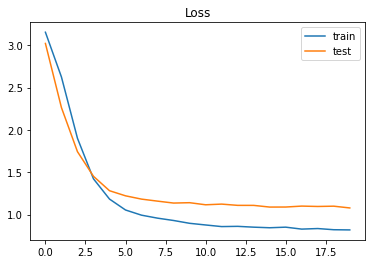

In [24]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

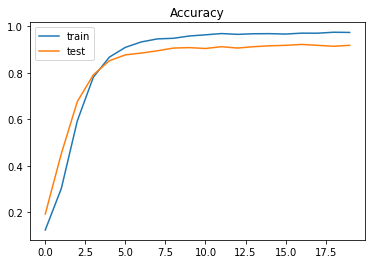

In [26]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Function to generate flair which will be used in the application script

In [0]:
def generate_flair(title):
  title = [title]
  seq = tokenizer.texts_to_sequences(title)
  padded = pad_sequences(seq, maxlen = max_seq_length)
  pred = model.predict(padded)
  return list_classes[np.argmax(pred)]

Storing the model in a pickle file

In [0]:
import pickle
pickle.dump(model, open('lstm_model2.pkl','wb'))

Loading the model

In [29]:
model = pickle.load(open('lstm_model2.pkl','rb'))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

